# Systems Identification Model Fitting

Fit a Systems Identification model off based off of this [specification](https://hackmd.io/w-vfdZIMTDKwdEupeS3qxQ) as derived in [data_acquisition.ipynb](data/data_acquisition.ipynb)


In [55]:
# import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

states = pd.read_csv('data/states.csv')
states.head()

,Unnamed: 0,marketPriceEth,marketPriceUsd,block_number,debtAvailableToSettle,erc20CoinTotalSupply,globalDebt,globalDebtCeiling,systemSurplus,totalActiveSafeCount,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,RAIInUniswapV2(RAI/ETH),collateral,debt,ETH Price (OSM)
0,0,0.001097,3.038342,12343350.0,110222.072759,2.990122e+07,3.030963e+07,1.157921e+32,224559.857661,630.0,0.959092,0.999995,0.999962,3.013189,1.876103e+07,1482.8032,327195.92226,2759.543733
1,1,0.001097,3.038342,12343097.0,110222.072759,2.990202e+07,3.031043e+07,1.157921e+32,224559.857661,631.0,0.919605,0.999990,0.999923,3.013209,1.876120e+07,1482.8032,327195.92226,2745.469394
2,2,0.001097,3.038342,12342826.0,110222.072759,2.990282e+07,3.031123e+07,1.157921e+32,224559.857661,632.0,0.919605,0.999990,0.999923,3.013265,1.874635e+07,1482.8032,327195.92226,2749.848368
3,3,0.001097,3.016169,12342586.0,110222.072759,2.990282e+07,3.031179e+07,1.157921e+32,224454.928369,632.0,0.919605,0.999990,0.999923,3.013265,1.876217e+07,1482.8032,327195.92226,2733.914147
4,4,0.001097,3.016169,12342308.0,110222.072759,2.990533e+07,3.031428e+07,1.157921e+32,224454.928369,633.0,0.919605,0.999990,0.999923,3.013296,1.875978e+07,1482.8032,327195.92226,2751.484809


## Analyze and Prepare Data

In [56]:
# drop unneeded column
del states['Unnamed: 0']
states_diff = states.diff()
# remove block number diff
del states_diff['block_number']
# add back block number
states_diff['block_number'] = states.block_number[:-6]
# drop first rows
states_diff = states_diff.iloc[1:]


In [57]:
states.describe()

,marketPriceEth,marketPriceUsd,block_number,debtAvailableToSettle,erc20CoinTotalSupply,globalDebt,globalDebtCeiling,systemSurplus,totalActiveSafeCount,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,RAIInUniswapV2(RAI/ETH),collateral,debt,ETH Price (OSM)
count,1781.000000,1781.000000,1.781000e+03,1781.000000,1.781000e+03,1.781000e+03,1.781000e+03,1781.000000,1781.000000,1781.000000,1781.000000,1781.000000,1781.000000,1.781000e+03,1781.000000,1.781000e+03,1781.000000
mean,0.001650,3.116462,1.210268e+07,173944.561828,3.393945e+07,3.430273e+07,1.157921e+32,151331.110240,832.632229,0.878979,0.999977,0.999815,3.043421,2.880546e+07,5978.191361,1.286463e+06,1942.128945
std,0.000332,0.313765,1.391693e+05,300992.835394,1.031133e+07,1.037980e+07,6.667199e+17,65894.438689,216.071391,0.287855,0.000048,0.000386,0.040165,1.054243e+07,2391.535506,5.616421e+05,321.751817
min,0.001086,2.833647,1.186179e+07,0.000000,3.048440e+03,3.048646e+03,1.157921e+32,-4410.287296,3.000000,0.168066,0.999796,0.998373,3.013189,6.019337e+02,16.892360,3.048358e+03,1328.192602
25%,0.001418,2.997393,1.198232e+07,2407.254511,3.049651e+07,3.075841e+07,1.157921e+32,144807.382516,747.000000,0.708873,0.999961,0.999686,3.016815,2.037981e+07,5751.673200,1.118623e+06,1712.192392
50%,0.001656,3.050387,1.210255e+07,27543.330150,3.419849e+07,3.469528e+07,1.157921e+32,173512.579677,903.000000,0.920093,0.999990,0.999924,3.025972,3.112297e+07,6602.213200,1.397867e+06,1844.860000
75%,0.001797,3.137597,1.222326e+07,112629.327270,4.076020e+07,4.118118e+07,1.157921e+32,193179.642819,990.000000,1.074397,1.000008,1.000066,3.041333,3.542900e+07,7131.013200,1.594694e+06,2143.842087
max,0.003962,7.138834,1.234335e+07,943944.359793,4.899876e+07,4.918820e+07,1.157921e+32,224559.857661,1021.000000,1.562592,1.000051,1.000408,3.140000,4.526982e+07,11399.720000,2.789440e+06,2788.113318


In [58]:
states_diff.head()

,marketPriceEth,marketPriceUsd,debtAvailableToSettle,erc20CoinTotalSupply,globalDebt,globalDebtCeiling,systemSurplus,totalActiveSafeCount,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,RAIInUniswapV2(RAI/ETH),collateral,debt,ETH Price (OSM),block_number
1,0.000000e+00,0.000000,0.000000,802.385750,799.082672,0.0,0.000000,1.0,-0.039487,-0.000005,-0.000038,0.000020,169.160808,0.0,0.00000,-14.074339,12343097.0
2,0.000000e+00,0.000000,0.000000,802.978307,799.672789,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000056,-14847.541791,0.0,0.00000,4.378973,12342826.0
3,1.222238e-07,-0.022173,0.000000,0.000000,562.747347,0.0,-104.929292,0.0,0.000000,0.000000,0.000000,0.000000,15815.052559,0.0,0.00000,-15.934221,12342586.0
4,0.000000e+00,0.000000,0.000000,2503.012133,2492.725625,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000031,-2392.026311,0.0,0.00000,17.570662,12342308.0
5,0.000000e+00,0.000000,1203.736137,36094.899584,37150.298257,0.0,0.000000,1.0,0.036314,0.000004,0.000035,0.000027,31475.949552,115.0,35946.56212,-7.284809,12342006.0


In [59]:
states_diff.dropna(inplace=True)
states_diff.fillna(0,inplace=True)

In [60]:
states_diff.columns

Index(['marketPriceEth', 'marketPriceUsd', 'debtAvailableToSettle',
       'erc20CoinTotalSupply', 'globalDebt', 'globalDebtCeiling',
       'systemSurplus', 'totalActiveSafeCount', 'RedemptionRateAnnualizedRate',
       'RedemptionRateHourlyRate', 'RedemptionRateEightHourlyRate',
       'RedemptionPrice', 'RAIInUniswapV2(RAI/ETH)', 'collateral', 'debt',
       'ETH Price (OSM)', 'block_number'],
      dtype='object')

In [79]:
# globalDebtCeiling causes an error 
subset_states_diff = states_diff[['marketPriceEth', 'marketPriceUsd','erc20CoinTotalSupply',
                                  'RedemptionRateHourlyRate','ETH Price (OSM)','systemSurplus',
                                 'RAIInUniswapV2(RAI/ETH)', 'collateral', 'debt']]

In [90]:
# globalDebtCeiling causes an error 
subset_states = states[['marketPriceEth', 'marketPriceUsd','erc20CoinTotalSupply',
                                  'RedemptionRateHourlyRate','ETH Price (OSM)','systemSurplus',
                                 'RAIInUniswapV2(RAI/ETH)', 'collateral', 'debt']]
states_log_diff = np.log(subset_states).diff().dropna()
states_log_diff.describe()

<ipython-input-90-b6fdb6fcbe6a>:5: RuntimeWarning: invalid value encountered in log
  states_log_diff = np.log(subset_states).diff().dropna()


,marketPriceEth,marketPriceUsd,erc20CoinTotalSupply,RedemptionRateHourlyRate,ETH Price (OSM),systemSurplus,RAIInUniswapV2(RAI/ETH),collateral,debt
count,1769.000000,1769.000000,1769.000000,1.769000e+03,1769.000000,1769.000000,1769.000000,1769.000000,1769.000000
mean,0.000283,0.000055,-0.005130,1.048962e-08,-0.000232,-0.008609,-0.005609,-0.002533,-0.002645
std,0.035294,0.035605,0.084333,7.082450e-06,0.010460,0.153795,0.134886,0.091580,0.091180
min,-0.574561,-0.577416,-3.065280,-9.142756e-05,-0.053961,-5.963348,-5.237646,-3.263626,-3.055354
25%,0.000000,-0.002196,-0.001313,0.000000e+00,-0.005041,-0.000513,-0.002315,0.000000,0.000000
50%,0.000000,0.000000,-0.000006,0.000000e+00,0.000000,-0.000253,-0.000045,0.000000,0.000000
75%,0.000875,0.002234,0.000217,0.000000e+00,0.003970,0.000000,0.000968,0.000000,0.000000
max,0.844642,0.850246,0.120688,1.037547e-04,0.089253,0.000000,0.286879,0.950276,0.807006


## Create model

In [93]:
aic = []
for i in range(1,26):
    model = sm.tsa.VAR(states_log_diff)
    results = model.fit(i,ic='aic')
    aic.append(results.aic)
    
    
bic = []
for i in range(1,26):
    model = sm.tsa.VAR(states_log_diff)
    results = model.fit(i,ic='bic')
    bic.append(results.bic)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmode

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmode

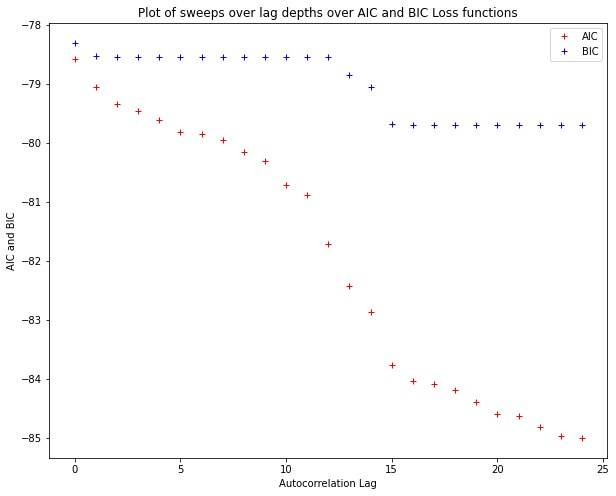

In [94]:
plt.figure(figsize=(10, 8))
plt.plot(aic, 'r+')
plt.plot(bic, 'b+')
plt.legend(['AIC','BIC'])
plt.xlabel('Autocorrelation Lag')
plt.ylabel('AIC and BIC')
plt.title('Plot of sweeps over lag depths over AIC and BIC Loss functions')
plt.show()

In [96]:
# instantiate the var model object from statsmodels
model = sm.tsa.VAR(states_log_diff)

# fit model with determined lag values
results = model.fit(1)

results.summary()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 03, May, 2021
Time:                     16:23:41
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -78.3070
Nobs:                     1768.00    HQIC:                  -78.4829
Log likelihood:           46981.8    FPE:                7.42312e-35
AIC:                     -78.5859    Det(Omega_mle):     7.05572e-35
--------------------------------------------------------------------
Results for equation marketPriceEth
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                               0.001421         0.000758            1.876           0.061
L1.marketPriceEth                  -0.082289         0.072793           -1.130           0

In [103]:
results.coefs[0][0]

array([-0.08228938,  0.07574091,  0.32752942,  8.46475229, -0.21359419,
        0.08144533, -0.2379064 ,  0.0858878 , -0.03639235])

In [104]:
results.resid

,marketPriceEth,marketPriceUsd,erc20CoinTotalSupply,RedemptionRateHourlyRate,ETH Price (OSM),systemSurplus,RAIInUniswapV2(RAI/ETH),collateral,debt
2,-0.002480,-0.001970,0.003088,-1.953767e-07,0.000557,0.007500,0.003645,-0.001413,-0.002311
3,-0.001167,-0.008626,0.002615,-2.518037e-09,-0.005651,0.006828,0.003496,0.000490,0.000216
4,-0.001860,-0.000976,0.003126,1.978922e-07,0.006830,0.002022,0.003587,-0.001037,0.002052
5,-0.000111,-0.000769,0.004023,4.562011e-06,-0.002549,0.008555,0.004113,0.076523,0.104516
6,-0.007685,-0.007482,0.005166,2.686944e-07,0.005659,0.012091,-0.003845,0.000957,-0.002382
...,...,...,...,...,...,...,...,...,...
1776,-0.075310,-0.092839,-0.086829,1.308052e-05,-0.010999,0.468430,-0.001306,-0.058922,-0.083488
1777,0.218813,0.217092,0.266592,2.697138e-07,-0.010152,-0.853616,0.346643,0.210149,0.274909
1778,-0.005472,-0.002910,0.003691,-7.750640e-07,0.005992,0.003873,0.007197,-0.002770,0.001912
1779,-0.000220,-0.003219,0.002966,1.179383e-07,0.000116,-0.087236,0.002790,0.001804,0.000484
